In [2]:
import numpy as np
import pandas as pd
import re
from re import sub
import multiprocessing
from unidecode import unidecode

from gensim.models.phrases import Phrases, Phraser
from gensim.models import Word2Vec
from gensim.test.utils import get_tmpfile
from gensim.models import KeyedVectors


from time import time 
from collections import defaultdict

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import string
import stop_words
from stop_words import get_stop_words

import logging  # Setting up the loggings to monitor gensim
logging.basicConfig(format="%(levelname)s - %(asctime)s: %(message)s", datefmt= '%H:%M:%S', level=logging.INFO)


In [3]:
df = pd.read_csv('Data/tweets_df.csv')
df = df.iloc[: , 1:] #dropping the first column of indexes

In [4]:
df.head()

,Date,Text,Likes,Source,entity
0,2021-10-30 23:59:46+00:00,$BEST inc short float is 24.80%\n\nWhen is the...,2,"<a href=""https://mobile.twitter.com"" rel=""nofo...",$GME
1,2021-10-30 23:55:43+00:00,I THINK EVERYONE INVESTED IN $AMC OR $GME SHOU...,491,"<a href=""https://mobile.twitter.com"" rel=""nofo...",$GME
2,2021-10-30 23:55:13+00:00,@2killmokingbird @shortdestroyer @traintickets...,5,"<a href=""https://mobile.twitter.com"" rel=""nofo...",$GME
3,2021-10-30 23:54:39+00:00,$amc $gme https://t.co/CJoSARve9v,1,"<a href=""http://twitter.com/download/android"" ...",$GME
4,2021-10-30 23:53:48+00:00,A Massive $Brandable #Domain For Sale:\n\nhttp...,2,"<a href=""https://mobile.twitter.com"" rel=""nofo...",$GME


In [5]:
df.shape

(92636, 5)

In [6]:
#dropping duplicates and resetting index
df = df.drop_duplicates(['Text'])
df = df.reset_index(drop=True)

def remove_pattern(input_txt, pattern):
    r = re.findall(pattern, input_txt)
    for i in r:
        input_txt = re.sub(i, '', input_txt)        
    return input_txt

def clean_tweets(tweets):
    #remove twitter Return handles (RT @xxx:)
    tweets = np.vectorize(remove_pattern)(tweets, "RT @[\w]*:") 
    
    #remove twitter handles (@xxx)
    tweets = np.vectorize(remove_pattern)(tweets, "@[\w]*")
    
    #remove URL links (httpxxx)
    tweets = np.vectorize(remove_pattern)(tweets, "https?://[A-Za-z0-9./]*")
    
    #remove special characters, numbers, punctuations (except for #)
    tweets = np.core.defchararray.replace(tweets, "[^a-zA-Z]", " ")
    
    return tweets

df['Text'] = clean_tweets(df['Text'])
df['Text'].head()

0    $BEST inc short float is 24.80%\n\nWhen is the...
1    I THINK EVERYONE INVESTED IN $AMC OR $GME SHOU...
2        I sold a very infamous ticker the other da...
3                                           $amc $gme 
4    A Massive $Brandable #Domain For Sale:\n\n \nM...
Name: Text, dtype: object

In [7]:
stop_words1 = set(stopwords.words('english')) #from nltk corpus
stop_words2 = list(get_stop_words('en')) #from stop_words library
tickers = ['$GME', '$AMC', '$UPST', '$GOOGL', '$AAPL', '$MSFT', '$SAVA', '$AMZN', '$BB', '$BBY']

#removing stopwords and tickers from text
df['Text'] = df['Text'].apply(lambda x: ' '.join(
    [word for word in x.split() if word not in (stop_words1) and (stop_words2)]))

In [8]:
print(len(stop_words1))
print(len(stop_words2))

179
174


In [6]:
def text_to_word_list(text):
    text = str(text)
    text = text.lower()

    # extra cleaning
    text = sub(r"[^A-Za-z0-9^,!?.\/'+]", " ", text)
    text = sub(r"\+", " plus ", text)
    text = sub(r",", " ", text)
    text = sub(r"\.", " ", text)
    text = sub(r"!", " ! ", text)
    text = sub(r"\?", " ? ", text)
    text = sub(r"'", " ", text)
    text = sub(r":", " : ", text)
    text = sub(r"\s{2,}", " ", text)

    text = text.split()

    return text  

In [7]:
df.Text = df.Text.apply(lambda x: text_to_word_list(x))

In [8]:
df.head()

,Date,Text,Likes,Source,entity
0,2021-10-30 23:59:46+00:00,"[best, inc, short, float, 24, 80, when, squeez...",2,"<a href=""https://mobile.twitter.com"" rel=""nofo...",$GME
1,2021-10-30 23:55:43+00:00,"[i, think, everyone, invested, in, amc, or, gm...",491,"<a href=""https://mobile.twitter.com"" rel=""nofo...",$GME
2,2021-10-30 23:55:13+00:00,"[i, sold, infamous, ticker, day, 350, profit, ...",5,"<a href=""https://mobile.twitter.com"" rel=""nofo...",$GME
3,2021-10-30 23:54:39+00:00,"[amc, gme]",1,"<a href=""http://twitter.com/download/android"" ...",$GME
4,2021-10-30 23:53:48+00:00,"[a, massive, brandable, domain, for, sale, mar...",2,"<a href=""https://mobile.twitter.com"" rel=""nofo...",$GME


In [9]:
df.shape

(79821, 5)

### Word2Vec

In [10]:
sent = [row for row in df.Text]
phrases = Phrases(sent, min_count=1, progress_per=50000)
bigram = Phraser(phrases)
sentences = bigram[sent]

INFO - 18:53:24: collecting all words and their counts
INFO - 18:53:24: PROGRESS: at sentence #0, processed 0 words and 0 word types
INFO - 18:53:26: PROGRESS: at sentence #50000, processed 1005862 words and 510111 word types
INFO - 18:53:27: collected 753154 token types (unigram + bigrams) from a corpus of 1589798 words and 79821 sentences
INFO - 18:53:27: merged Phrases<753154 vocab, min_count=1, threshold=10.0, max_vocab_size=40000000>
INFO - 18:53:27: Phrases lifecycle event {'msg': 'built Phrases<753154 vocab, min_count=1, threshold=10.0, max_vocab_size=40000000> in 2.27s', 'datetime': '2021-12-04T18:53:27.008778', 'gensim': '4.1.2', 'python': '3.8.12 (default, Oct 12 2021, 03:01:40) [MSC v.1916 64 bit (AMD64)]', 'platform': 'Windows-10-10.0.19043-SP0', 'event': 'created'}
INFO - 18:53:27: exporting phrases from Phrases<753154 vocab, min_count=1, threshold=10.0, max_vocab_size=40000000>
INFO - 18:53:28: FrozenPhrases lifecycle event {'msg': 'exported FrozenPhrases<53051 phrases, m

In [11]:
w2v_model = Word2Vec(min_count=3,
                     window=4,
                     vector_size=300,
                     sample=1e-5, 
                     alpha=0.03, 
                     min_alpha=0.0007, 
                     negative=20,
                     workers=multiprocessing.cpu_count()-1)

start = time()

w2v_model.build_vocab(sentences, progress_per=50000)

print('Time to build vocab: {} mins'.format(round((time() - start) / 60, 2)))


INFO - 18:53:36: Word2Vec lifecycle event {'params': 'Word2Vec(vocab=0, vector_size=300, alpha=0.03)', 'datetime': '2021-12-04T18:53:36.095625', 'gensim': '4.1.2', 'python': '3.8.12 (default, Oct 12 2021, 03:01:40) [MSC v.1916 64 bit (AMD64)]', 'platform': 'Windows-10-10.0.19043-SP0', 'event': 'created'}
INFO - 18:53:36: collecting all words and their counts
INFO - 18:53:36: PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
INFO - 18:53:37: PROGRESS: at sentence #50000, processed 839319 words, keeping 68620 word types
INFO - 18:53:37: collected 89789 word types from a corpus of 1322194 raw words and 79821 sentences
INFO - 18:53:37: Creating a fresh vocabulary
INFO - 18:53:38: Word2Vec lifecycle event {'msg': 'effective_min_count=3 retains 37760 unique words (42.054149171947564%% of original 89789, drops 52029)', 'datetime': '2021-12-04T18:53:38.112252', 'gensim': '4.1.2', 'python': '3.8.12 (default, Oct 12 2021, 03:01:40) [MSC v.1916 64 bit (AMD64)]', 'platform': 'Windo

Time to build vocab: 0.05 mins


In [12]:
w2v_model.save("word2vec.model")

INFO - 18:53:41: Word2Vec lifecycle event {'fname_or_handle': 'word2vec.model', 'separately': 'None', 'sep_limit': 10485760, 'ignore': frozenset(), 'datetime': '2021-12-04T18:53:41.429437', 'gensim': '4.1.2', 'python': '3.8.12 (default, Oct 12 2021, 03:01:40) [MSC v.1916 64 bit (AMD64)]', 'platform': 'Windows-10-10.0.19043-SP0', 'event': 'saving'}
INFO - 18:53:41: storing np array 'vectors' to word2vec.model.wv.vectors.npy
INFO - 18:53:41: storing np array 'syn1neg' to word2vec.model.syn1neg.npy
INFO - 18:53:41: not storing attribute cum_table
INFO - 18:53:41: saved word2vec.model


In [13]:
df.to_csv('Data/lemma_tweets_df.csv')

In [18]:
w2v_model.wv.most_similar(negative=["bearish"])

[('their', 0.25109899044036865),
 ('rt_nio', 0.2398056983947754),
 ('plug_ada', 0.23929455876350403),
 ('marching', 0.23512135446071625),
 ('btx', 0.23292715847492218),
 ('bidu_baba', 0.2291838526725769),
 ('introduces', 0.21706560254096985),
 ('lets_see', 0.21530334651470184),
 ('curevac_cvac', 0.2105555534362793),
 ('tgls', 0.2039554864168167)]

In [25]:
w2v_model.wv.similarity("bearish", 'buy')

0.03167111

In [3]:
import numpy as np
import pandas as pd

iee_data = pd.read_csv('Data/tweets_labelled_09042020_16072020.csv',sep=';')

In [5]:
iee_data.dropna()

,id,created_at,text,sentiment
0,77522,2020-04-15 01:03:46+00:00,"RT @RobertBeadles: Yo💥\nEnter to WIN 1,000 Mon...",positive
1,661634,2020-06-25 06:20:06+00:00,#SriLanka surcharge on fuel removed!\n⛽📉\nThe ...,negative
2,413231,2020-06-04 15:41:45+00:00,Net issuance increases to fund fiscal programs...,positive
3,760262,2020-07-03 19:39:35+00:00,RT @bentboolean: How much of Amazon's traffic ...,positive
4,830153,2020-07-09 14:39:14+00:00,$AMD Ryzen 4000 desktop CPUs looking ‘great’ a...,positive
...,...,...,...,...
1295,75519,2020-04-15 06:00:10+00:00,#stocks back from the recovery room: https://t...,positive
1296,739234,2020-07-01 11:29:10+00:00,RT @MacroCharts: Breadth – expanding last week...,positive
1297,254379,2020-04-29 02:21:50+00:00,RT @MawsonResource: Rompas-Rajapalot: A Big Ne...,neutral
1298,580441,2020-06-19 17:56:57+00:00,$AAPL $QQQ Top may now be in. https://t.co/iNK...,positive


[Text(0, 0, 'Negative'), Text(1, 0, 'Neutral'), Text(2, 0, 'Positive')]

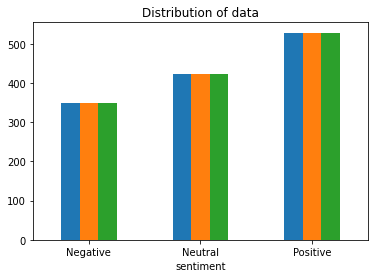

In [6]:
# Plotting the distribution for dataset.
ax = iee_data.groupby('sentiment').count().plot(kind='bar', title='Distribution of data',legend=False)
ax.set_xticklabels(['Negative', 'Neutral', 'Positive'], rotation=0)